# 🚗 POTHOLE DETECTION - EfficientNetB0 Transfer Learning
## Fast & Accurate Model
---

## 🔧 SETUP

In [1]:
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import cv2, json, pickle, warnings
from datetime import datetime
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print(f"✅ TensorFlow {tf.__version__} ready!")

✅ TensorFlow 2.20.0 ready!


In [2]:
# Config - Orange & Black Theme
COLOR_SCHEME = {
    'primary': '#E65100', 'secondary': '#F57C00', 'accent': '#FF9800',
    'light': '#FFE0B2', 'dark': '#1A1A1A', 'pothole': '#FF6F00', 'nopothole': '#FFE0B2'
}

CONFIG = {
    'DATASET_PATH': r'C:\UAP_MachineLearning\DatasetUAP',
    'OUTPUT_PATH': r'C:\UAP_MachineLearning\EfficientNet',
    'IMG_SIZE': (224, 224), 'BATCH_SIZE': 32, 'EPOCHS': 5,
    'LEARNING_RATE': 0.0001, 'CLASSES': ['NOPOTHOLE', 'POTHOLE'], 'NUM_CLASSES': 2
}

for d in ['EDA', 'Model', 'Training', 'Evaluation', 'XAI']:
    os.makedirs(os.path.join(CONFIG['OUTPUT_PATH'], d), exist_ok=True)

print("✅ Config ready! Theme: Orange & Black")

✅ Config ready! Theme: Orange & Black


## 📊 DETAILED EDA

In [3]:
def count_images(d):
    return {'POTHOLE': len(glob.glob(os.path.join(d, 'POTHOLE_*'))),
            'NOPOTHOLE': len(glob.glob(os.path.join(d, 'NOPOTHOLE_*')))}

train_c = count_images(os.path.join(CONFIG['DATASET_PATH'], 'train'))
valid_c = count_images(os.path.join(CONFIG['DATASET_PATH'], 'valid'))
test_c = count_images(os.path.join(CONFIG['DATASET_PATH'], 'test'))

data_summary = pd.DataFrame({
    'Dataset': ['Train', 'Valid', 'Test'],
    'Pothole': [train_c['POTHOLE'], valid_c['POTHOLE'], test_c['POTHOLE']],
    'No Pothole': [train_c['NOPOTHOLE'], valid_c['NOPOTHOLE'], test_c['NOPOTHOLE']]
})
data_summary['Total'] = data_summary['Pothole'] + data_summary['No Pothole']
data_summary['Pothole %'] = (data_summary['Pothole'] / data_summary['Total'] * 100).round(2)

print("📊 Dataset Statistics:")
print(data_summary)
print(f"\nTotal: {data_summary['Total'].sum()} images")
print(f"Class Balance: {data_summary['Pothole'].sum()}/{data_summary['No Pothole'].sum()}")

📊 Dataset Statistics:
  Dataset  Pothole  No Pothole  Total  Pothole %
0   Train     2013        1912   3925      51.29
1   Valid      592         584   1176      50.34
2    Test      297         295    592      50.17

Total: 5693 images
Class Balance: 2902/2791


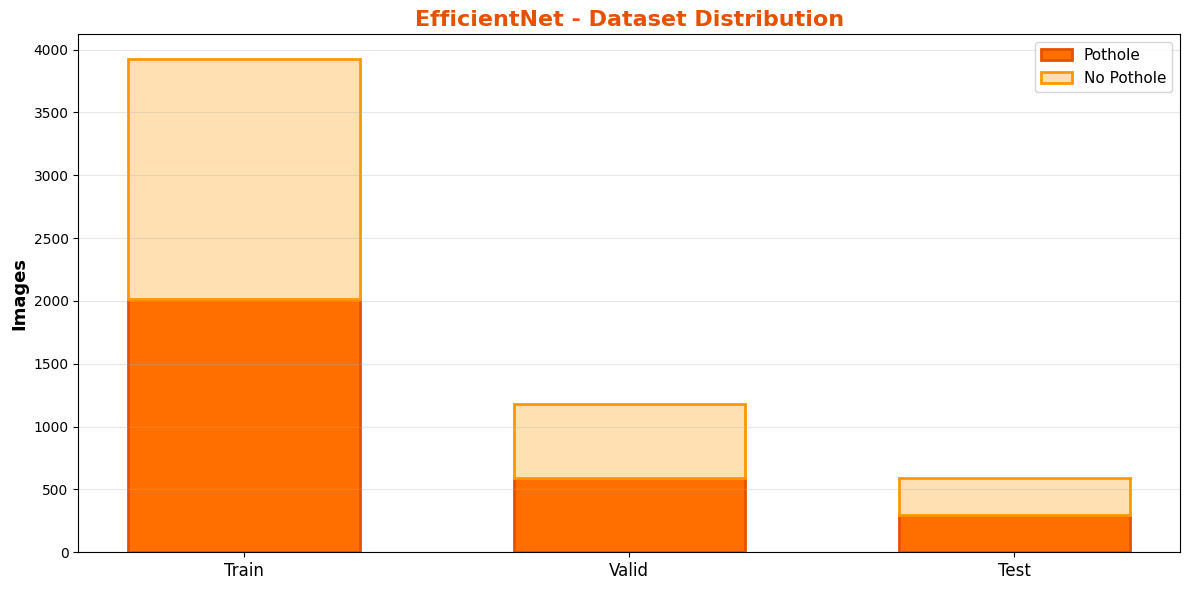

✅ Distribution chart saved


In [4]:
# EDA Viz 1: Stacked Bar
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(data_summary))
ax.bar(x, data_summary['Pothole'], 0.6, label='Pothole', color=COLOR_SCHEME['pothole'], edgecolor=COLOR_SCHEME['primary'], linewidth=2)
ax.bar(x, data_summary['No Pothole'], 0.6, bottom=data_summary['Pothole'], label='No Pothole', 
       color=COLOR_SCHEME['nopothole'], edgecolor=COLOR_SCHEME['accent'], linewidth=2)
ax.set_ylabel('Images', fontsize=13, weight='bold')
ax.set_title('EfficientNet - Dataset Distribution', fontsize=16, weight='bold', color=COLOR_SCHEME['primary'])
ax.set_xticks(x)
ax.set_xticklabels(data_summary['Dataset'], fontsize=12)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['OUTPUT_PATH'], 'EDA', 'distribution.png'), dpi=150)
plt.show()
print("✅ Distribution chart saved")

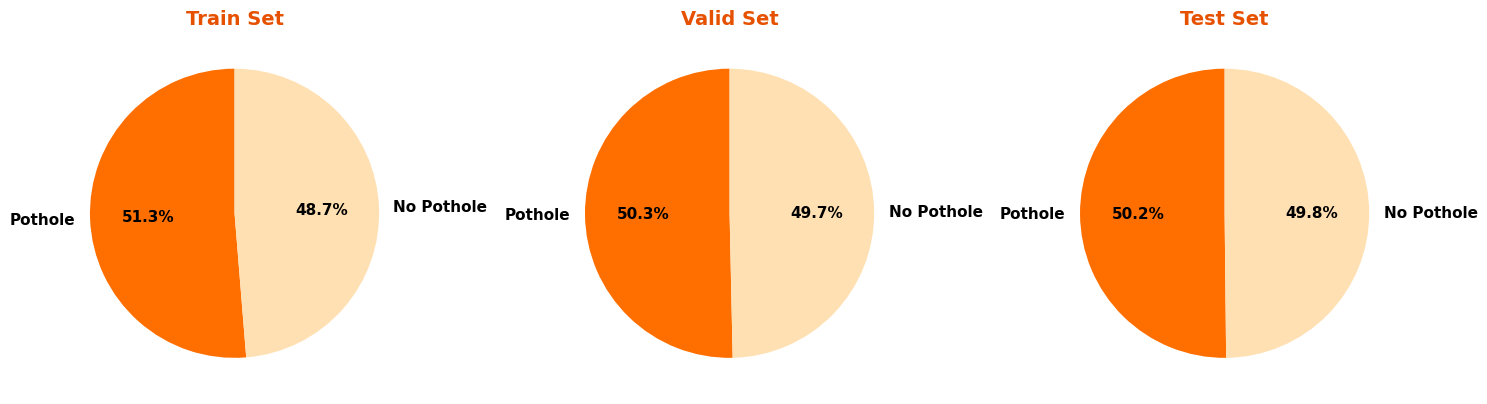

✅ Pie charts saved


In [5]:
# EDA Viz 2: Pie Chart
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, dataset in enumerate(['Train', 'Valid', 'Test']):
    row = data_summary[data_summary['Dataset'] == dataset].iloc[0]
    axes[idx].pie([row['Pothole'], row['No Pothole']], labels=['Pothole', 'No Pothole'],
                  colors=[COLOR_SCHEME['pothole'], COLOR_SCHEME['nopothole']], autopct='%1.1f%%',
                  startangle=90, textprops={'fontsize': 11, 'weight': 'bold'})
    axes[idx].set_title(f'{dataset} Set', fontsize=14, weight='bold', color=COLOR_SCHEME['primary'])
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['OUTPUT_PATH'], 'EDA', 'pie_charts.png'), dpi=150)
plt.show()
print("✅ Pie charts saved")

In [6]:
# Save EDA summary
data_summary.to_csv(os.path.join(CONFIG['OUTPUT_PATH'], 'EDA', 'dataset_summary.csv'), index=False)
print("✅ EDA summary saved")

✅ EDA summary saved


## 🔧 DATA LOADING

In [7]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def load_data(path, img_size=(224, 224)):
    images, labels = [], []
    for label, prefix in [(1, 'POTHOLE_'), (0, 'NOPOTHOLE_')]:
        files = glob.glob(os.path.join(path, prefix + '*'))
        for f in files:
            img = cv2.imread(f)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = preprocess_input(img)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

print("Loading data...")
X_train, y_train = load_data(os.path.join(CONFIG['DATASET_PATH'], 'train'), CONFIG['IMG_SIZE'])
X_valid, y_valid = load_data(os.path.join(CONFIG['DATASET_PATH'], 'valid'), CONFIG['IMG_SIZE'])
X_test, y_test = load_data(os.path.join(CONFIG['DATASET_PATH'], 'test'), CONFIG['IMG_SIZE'])

y_train_cat = to_categorical(y_train, 2)
y_valid_cat = to_categorical(y_valid, 2)
y_test_cat = to_categorical(y_test, 2)

print(f"✅ Train: {X_train.shape[0]}, Valid: {X_valid.shape[0]}, Test: {X_test.shape[0]}")

Loading data...
✅ Train: 3925, Valid: 1176, Test: 592


## 🏗️ BUILD MODEL

In [8]:
base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*CONFIG['IMG_SIZE'], 3))
base.trainable = False

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(CONFIG['LEARNING_RATE']), loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

print(f"✅ EfficientNetB0 ready! Trainable: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
✅ EfficientNetB0 ready! Trainable: 363,650


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,415,781 (16.84 MB)

 Trainable params: 363,650 (1.39 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

## 🎯 TRAINING

In [9]:
callbacks = [
    ModelCheckpoint(os.path.join(CONFIG['OUTPUT_PATH'], 'Model', 'best.keras'), monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7, verbose=1)
]

print("🚀 Training...")
history = model.fit(X_train, y_train_cat, batch_size=CONFIG['BATCH_SIZE'], epochs=CONFIG['EPOCHS'],
                    validation_data=(X_valid, y_valid_cat), callbacks=callbacks, verbose=1)

pd.DataFrame(history.history).to_csv(os.path.join(CONFIG['OUTPUT_PATH'], 'Training', 'history.csv'), index=False)
with open(os.path.join(CONFIG['OUTPUT_PATH'], 'Training', 'history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)
print("✅ Training done!")

🚀 Training...
Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.7175 - loss: 0.7148 - precision: 0.7175 - recall: 0.7175
Epoch 1: val_accuracy improved from -inf to 0.96684, saving model to C:\UAP_MachineLearning\EfficientNet\Model\best.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 91s 672ms/step - accuracy: 0.7184 - loss: 0.7126 - precision: 0.7184 - recall: 0.7184 - val_accuracy: 0.9668 - val_loss: 0.1673 - val_precision: 0.9668 - val_recall: 0.9668 - learning_rate: 1.0000e-04
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9313 - loss: 0.1937 - precision: 0.9313 - recall: 0.9313
Epoch 2: val_accuracy improved from 0.96684 to 0.97874, saving model to C:\UAP_MachineLearning\EfficientNet\Model\best.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 79s 642ms/step - accuracy: 0.9313 - loss: 0.1935 - precision: 0.9313 - recall: 0.9313 - val_accuracy: 0.9787 - val_loss: 0.0788 - val_precision: 0.9787 - val_recall: 0.9787 - learning_rate: 1.0000e-04
Epoch 3/5
123/123 ━━━━━━━━━━━━━

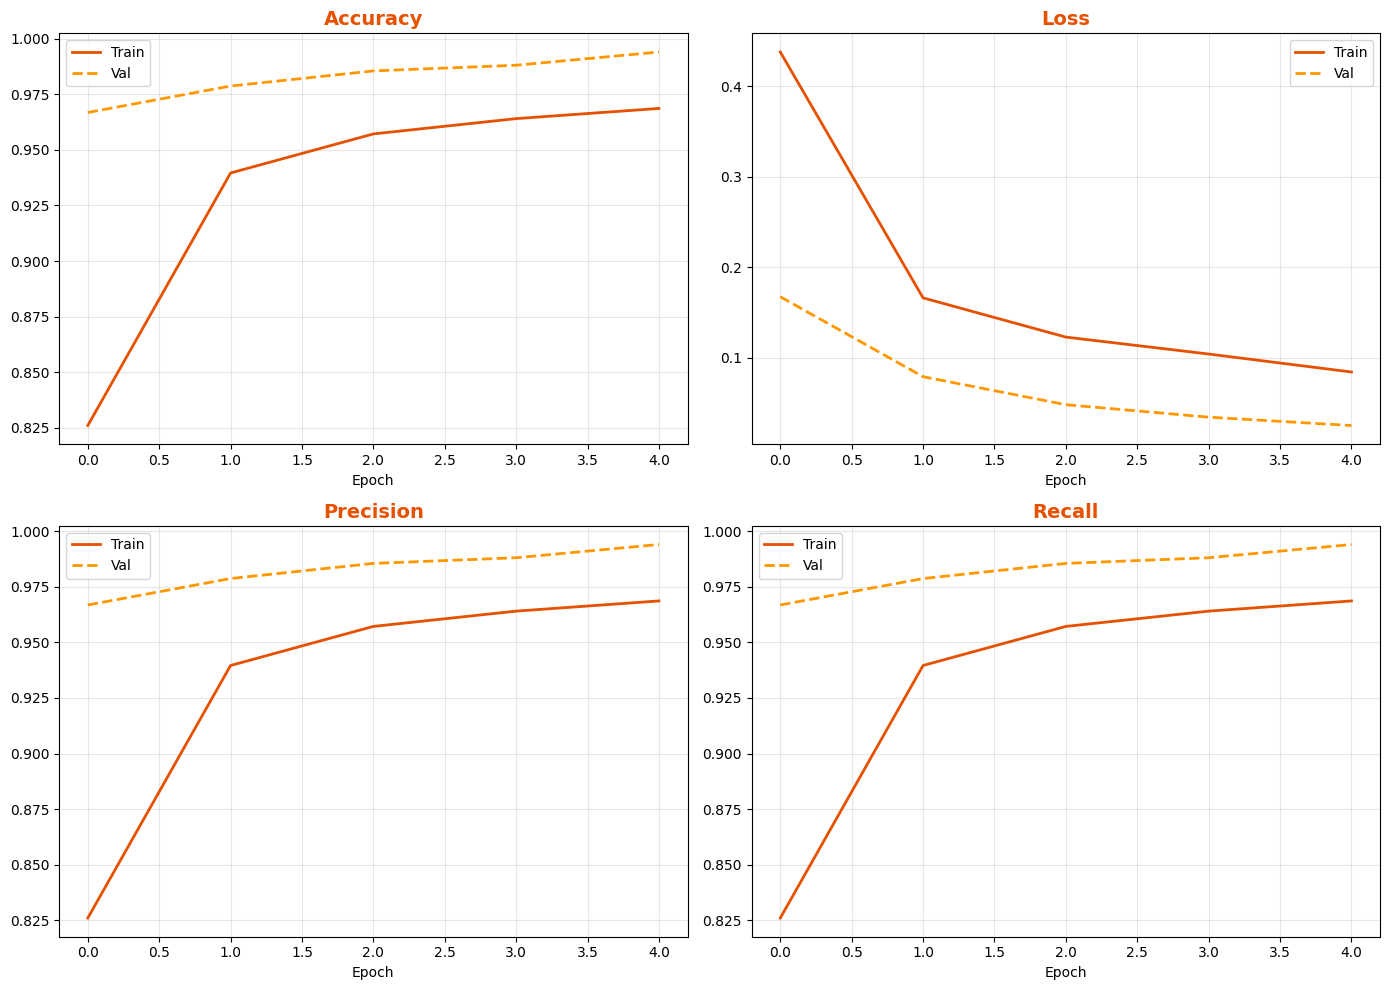

✅ Training viz saved


In [10]:
# Training Viz
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = [('accuracy', 'Accuracy'), ('loss', 'Loss'), ('precision', 'Precision'), ('recall', 'Recall')]
for idx, (metric, title) in enumerate(metrics):
    ax = axes[idx//2, idx%2]
    ax.plot(history.history[metric], label='Train', color=COLOR_SCHEME['primary'], linewidth=2)
    ax.plot(history.history[f'val_{metric}'], label='Val', color=COLOR_SCHEME['accent'], linewidth=2, linestyle='--')
    ax.set_title(title, fontsize=14, weight='bold', color=COLOR_SCHEME['primary'])
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['OUTPUT_PATH'], 'Training', 'metrics.png'), dpi=150)
plt.show()
print("✅ Training viz saved")

## 📈 EVALUATION

19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 616ms/step

TEST RESULTS:
              precision    recall  f1-score   support

   NOPOTHOLE       0.99      0.98      0.98       295
     POTHOLE       0.98      0.99      0.98       297

    accuracy                           0.98       592
   macro avg       0.98      0.98      0.98       592
weighted avg       0.98      0.98      0.98       592



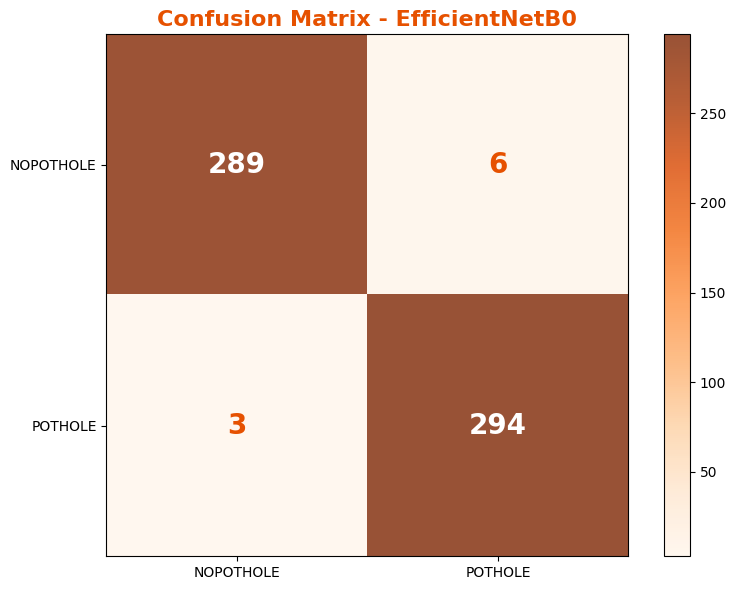

✅ Evaluation saved


In [11]:
test_pred = np.argmax(model.predict(X_test), axis=1)
print("\nTEST RESULTS:")
print(classification_report(y_test, test_pred, target_names=CONFIG['CLASSES']))

pd.DataFrame({
    'True': y_test, 'Pred': test_pred,
    'True_Class': [CONFIG['CLASSES'][i] for i in y_test],
    'Pred_Class': [CONFIG['CLASSES'][i] for i in test_pred],
    'Correct': y_test == test_pred
}).to_csv(os.path.join(CONFIG['OUTPUT_PATH'], 'Evaluation', 'predictions.csv'), index=False)

# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Oranges', alpha=0.8)
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(CONFIG['CLASSES'])
ax.set_yticklabels(CONFIG['CLASSES'])
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center", 
               color="white" if cm[i, j] > cm.max()/2 else COLOR_SCHEME['primary'], fontsize=20, weight='bold')
ax.set_title('Confusion Matrix - EfficientNetB0', fontsize=16, weight='bold', color=COLOR_SCHEME['primary'])
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['OUTPUT_PATH'], 'Evaluation', 'confusion_matrix.png'), dpi=150)
plt.show()
print("✅ Evaluation saved")

## 🎨 XAI

🎨 Generating Saliency Maps...
  ✓ Sample 1/6 completed
  ✓ Sample 2/6 completed
  ✓ Sample 3/6 completed
  ✓ Sample 4/6 completed
  ✓ Sample 5/6 completed
  ✓ Sample 6/6 completed


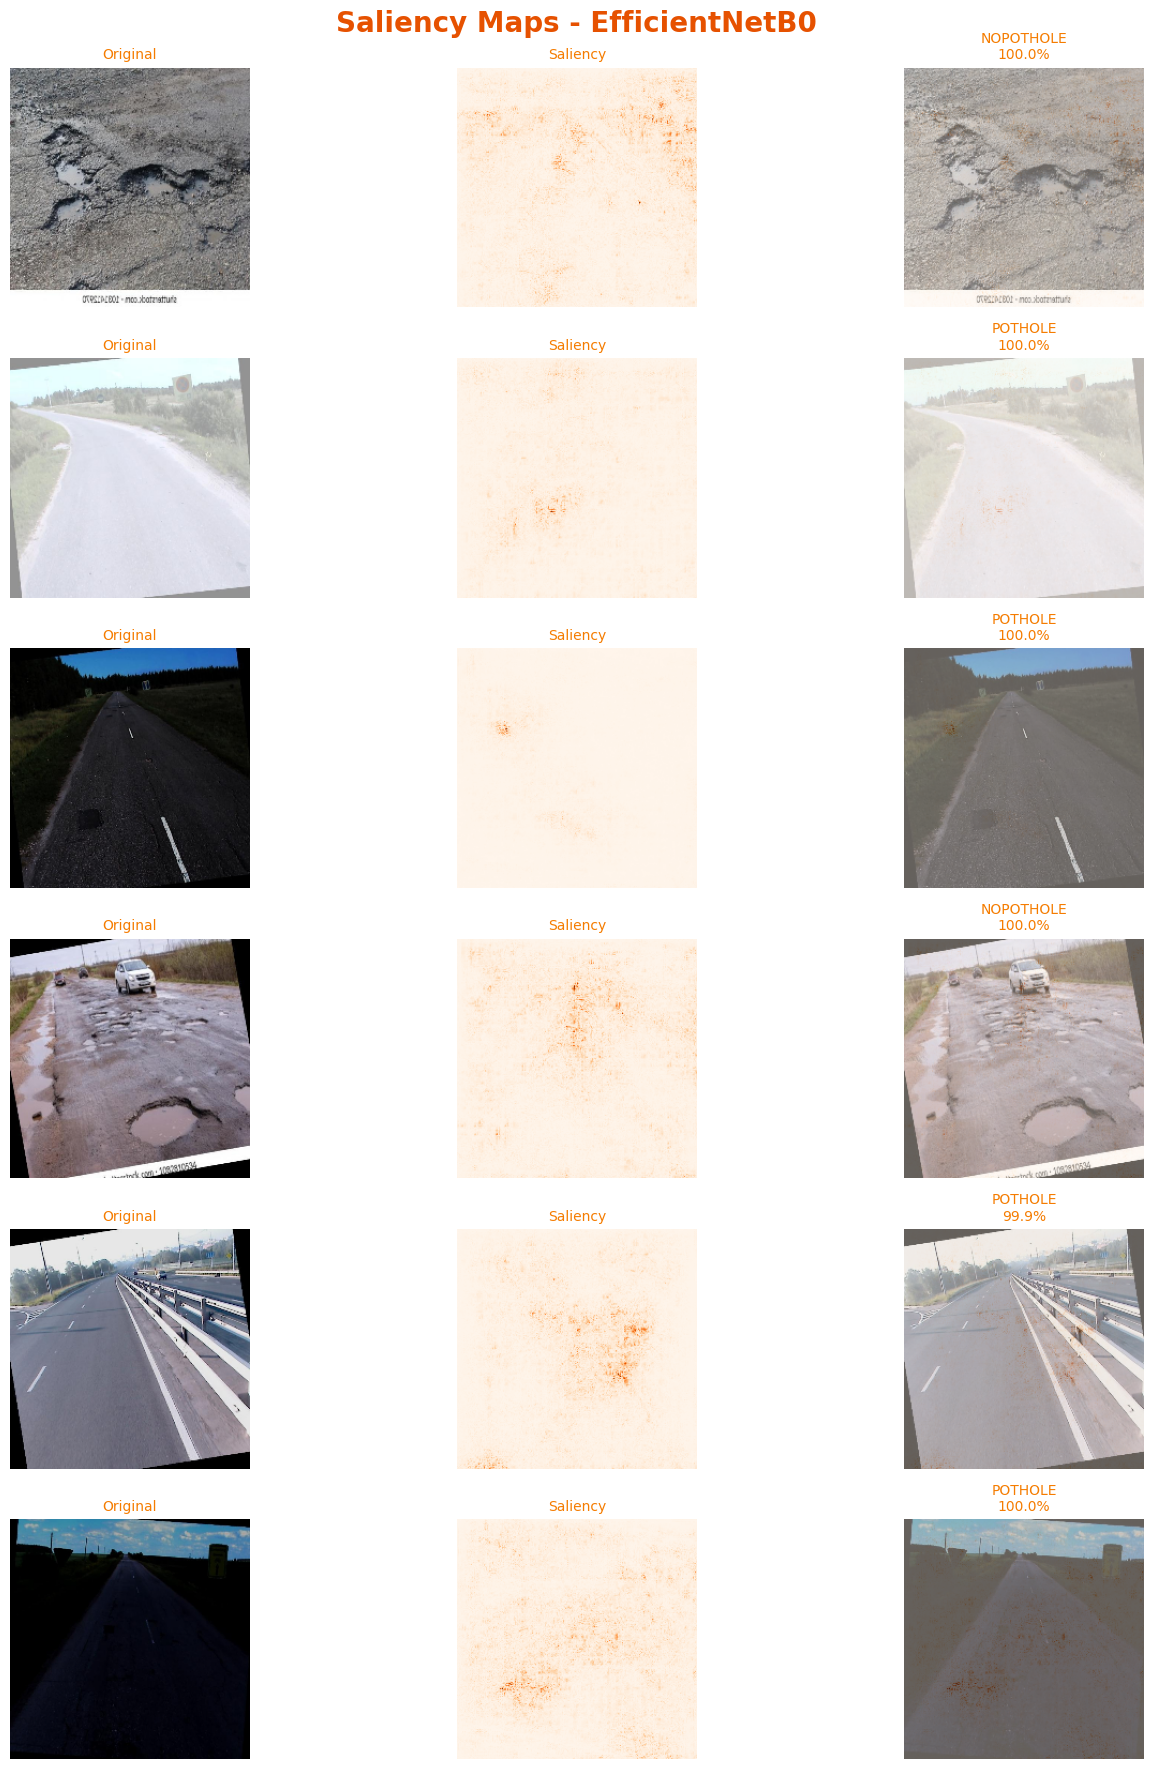


✅ XAI visualization saved!


In [14]:
# XAI - Saliency Map (FIXED - Original Image Display)
def saliency_map(img_array, model, pred_idx=None):
    """Generate saliency map"""
    img_tensor = tf.Variable(tf.cast(img_array, tf.float32))
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor, training=False)
        
        if pred_idx is None:
            pred_idx = tf.argmax(preds[0])
        
        pred_idx = int(pred_idx)
        target = preds[:, pred_idx]
    
    grads = tape.gradient(target, img_tensor)
    
    if grads is None:
        return np.zeros((img_array.shape[1], img_array.shape[2]))
    
    sal = tf.reduce_max(tf.abs(grads), axis=-1)[0].numpy()
    sal_min, sal_max = sal.min(), sal.max()
    
    if sal_max - sal_min < 1e-10:
        return sal
    
    return (sal - sal_min) / (sal_max - sal_min)


# Load ORIGINAL images (not preprocessed) for display
def load_original_image(img_idx, dataset='test'):
    """Load original image without preprocessing for display"""
    # Get image path from test set
    test_path = os.path.join(CONFIG['DATASET_PATH'], dataset)
    
    # Find the image file
    all_files = glob.glob(os.path.join(test_path, '*'))
    
    if img_idx < len(all_files):
        img_path = all_files[img_idx]
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, CONFIG['IMG_SIZE'])
            return img
    
    # Fallback: try to reverse EfficientNet preprocessing
    img = X_test[img_idx].copy()
    # EfficientNet preprocessing: (img - mean) / std
    # Reverse it approximately
    img = img * 64 + 128  # Approximate reverse
    img = np.clip(img, 0, 255).astype('uint8')
    return img


# Generate Saliency Maps
print("🎨 Generating Saliency Maps...")

# Get actual file paths for original images
test_path = os.path.join(CONFIG['DATASET_PATH'], 'test')
all_test_files = sorted(glob.glob(os.path.join(test_path, '*')))

samples = np.random.choice(len(X_test), 6, replace=False)
fig, axes = plt.subplots(6, 3, figsize=(15, 18), facecolor='white')
fig.suptitle('Saliency Maps - EfficientNetB0', fontsize=20, weight='bold', 
             color=COLOR_SCHEME['primary'])

for idx, img_idx in enumerate(samples):
    try:
        img_array = np.expand_dims(X_test[img_idx], 0)
        
        # Get prediction
        preds = model.predict(img_array, verbose=0)
        pred = np.argmax(preds[0])
        confidence = preds[0][pred]
        
        # Generate saliency map
        sal = saliency_map(img_array, model, pred)
        
        # Load ORIGINAL image (not preprocessed)
        if img_idx < len(all_test_files):
            img_path = all_test_files[img_idx]
            img_original = cv2.imread(img_path)
            img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
            img_original = cv2.resize(img_original, CONFIG['IMG_SIZE'])
        else:
            # Fallback
            img_original = load_original_image(img_idx)
        
        # Original image
        axes[idx, 0].imshow(img_original)
        axes[idx, 0].set_title('Original', fontsize=10, color=COLOR_SCHEME['secondary'])
        axes[idx, 0].axis('off')
        
        # Saliency map
        axes[idx, 1].imshow(sal, cmap='Oranges')
        axes[idx, 1].set_title('Saliency', fontsize=10, color=COLOR_SCHEME['secondary'])
        axes[idx, 1].axis('off')
        
        # Overlay
        sal_colored = (plt.cm.Oranges(sal)[:, :, :3] * 255).astype('uint8')
        overlay = (img_original * 0.6 + sal_colored * 0.4).astype('uint8')
        
        axes[idx, 2].imshow(overlay)
        axes[idx, 2].set_title(f'{CONFIG["CLASSES"][pred]}\n{confidence:.1%}', 
                              fontsize=10, color=COLOR_SCHEME['secondary'])
        axes[idx, 2].axis('off')
        
        print(f"  ✓ Sample {idx+1}/6 completed")
        
    except Exception as e:
        print(f"  ✗ Sample {idx+1} failed: {e}")
        axes[idx, 0].axis('off')
        axes[idx, 1].axis('off')
        axes[idx, 2].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['OUTPUT_PATH'], 'XAI', 'saliency.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ XAI visualization saved!")

## 💾 SAVE

In [15]:
model.save(os.path.join(CONFIG['OUTPUT_PATH'], 'Model', 'efficientnet_final.keras'))
model.save_weights(os.path.join(CONFIG['OUTPUT_PATH'], 'Model', 'efficientnet.weights.h5'))

summary = {
    'project': 'Pothole Detection - EfficientNetB0',
    'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': {'train': int(X_train.shape[0]), 'valid': int(X_valid.shape[0]), 'test': int(X_test.shape[0])},
    'performance': {
        'accuracy': float(accuracy_score(y_test, test_pred)),
        'precision': float(precision_score(y_test, test_pred)),
        'recall': float(recall_score(y_test, test_pred)),
        'f1': float(f1_score(y_test, test_pred))
    }
}

with open(os.path.join(CONFIG['OUTPUT_PATH'], 'summary.json'), 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=4)

print("\n🎉 COMPLETED!")
print(json.dumps(summary, indent=2))


🎉 COMPLETED!
{
  "project": "Pothole Detection - EfficientNetB0",
  "date": "2025-12-23 22:55:51",
  "dataset": {
    "train": 3925,
    "valid": 1176,
    "test": 592
  },
  "performance": {
    "accuracy": 0.9847972972972973,
    "precision": 0.98,
    "recall": 0.98989898989899,
    "f1": 0.9849246231155779
  }
}
